# GitLab dataset analysis
This notebook aims to analyse the dataset created on GitLab.
The goal is to compare it with the dataset from GitHub.

We will analyse:
1. The size of the dataset: number of bots/humans and the 3 sources.
2. The difference of features between bots and humans in GitLab.
3. The difference of features between GitLab and GitHub (Bot in GitHub vs Bot in GitLab, ...)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from cliffs_delta import cliffs_delta


RESOURCE_FOLDER = '../../resources'

# Top 5 important features found in BIMBAS's paper + The number of activities
important_features = ['NA','NT', 'NOR', 'DCAT_median', 'NAT_median', 'NAT_mean']

## 1. General analysis

This dataset is slightly more imbalanced than the GitHub dataset, with a higher proportion of humans.

Reminder: GitHub had 48.12% of bots and 51.88% of humans.

In [2]:
# Load dataset
glmap_features = pd.read_csv(f"{RESOURCE_FOLDER}/data/gitlab/gitlab_glmap_features.csv")
glmap_features_humans = glmap_features[glmap_features['label'] == 'Human']
glmap_features_bots = glmap_features[glmap_features['label'] == 'Bot']

print(f"Number of contributors = {glmap_features.shape[0]}")
print(f"Number of Human = {glmap_features_humans.shape[0]} ({glmap_features_humans.shape[0] / glmap_features.shape[0] * 100:.2f}%)")
print(f"Number of Bot = {glmap_features_bots.shape[0]} ({glmap_features_bots.shape[0] / glmap_features.shape[0] * 100:.2f}%)")

Number of contributors = 593
Number of Human = 320 (53.96%)
Number of Bot = 273 (46.04%)


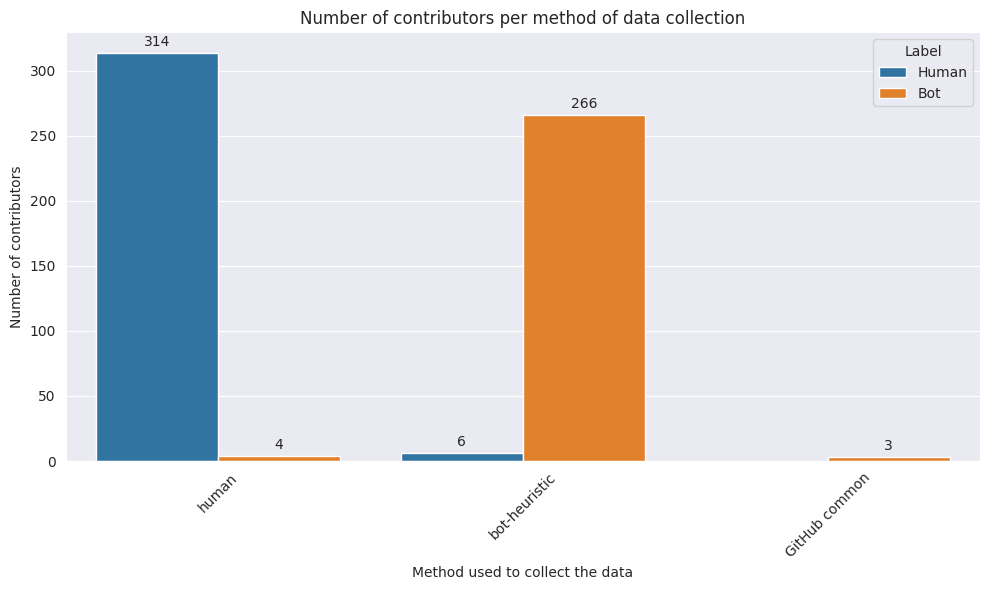

In [3]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.countplot(data=glmap_features, x='origin', hue='label', ax=ax)

# Add text labels on the bars
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', padding=3)

ax.set_title('Number of contributors per method of data collection')
plt.xticks(rotation=45)
plt.legend(title='Label')
plt.xlabel('Method used to collect the data')
plt.ylabel('Number of contributors')
plt.tight_layout()
plt.show()


# 2. Feature analysis (GitLab only)
In this section, we will compare the features between bots and humans.
The goal is to see if there are significant differences between the two groups.

For the top 5 important features of BIMBAS, the difference between bots and human remain significant.

Note: 162/273 bots (59.34%) contribute to only one repository. This leads to a lot of `null` values for the features that analyse the activities across repositories such as `DAAR`.

In [14]:
print(f"Number of bots with NR=1: {len(glmap_features_bots[glmap_features_bots['NR'] == 1])} ({len(glmap_features_bots[glmap_features_bots['NR'] == 1]) / len(glmap_features_bots):.4f})")

print(f"Number of Humans with NR=1: {len(glmap_features_humans[glmap_features_humans['NR'] == 1])} ({len(glmap_features_humans[glmap_features_humans['NR'] == 1]) / len(glmap_features_humans):.4f})")

Number of bots with NR=1: 162 (0.5934)
Number of Humans with NR=1: 42 (0.1313)


### 2.1 - Analysis of the plots of the main features

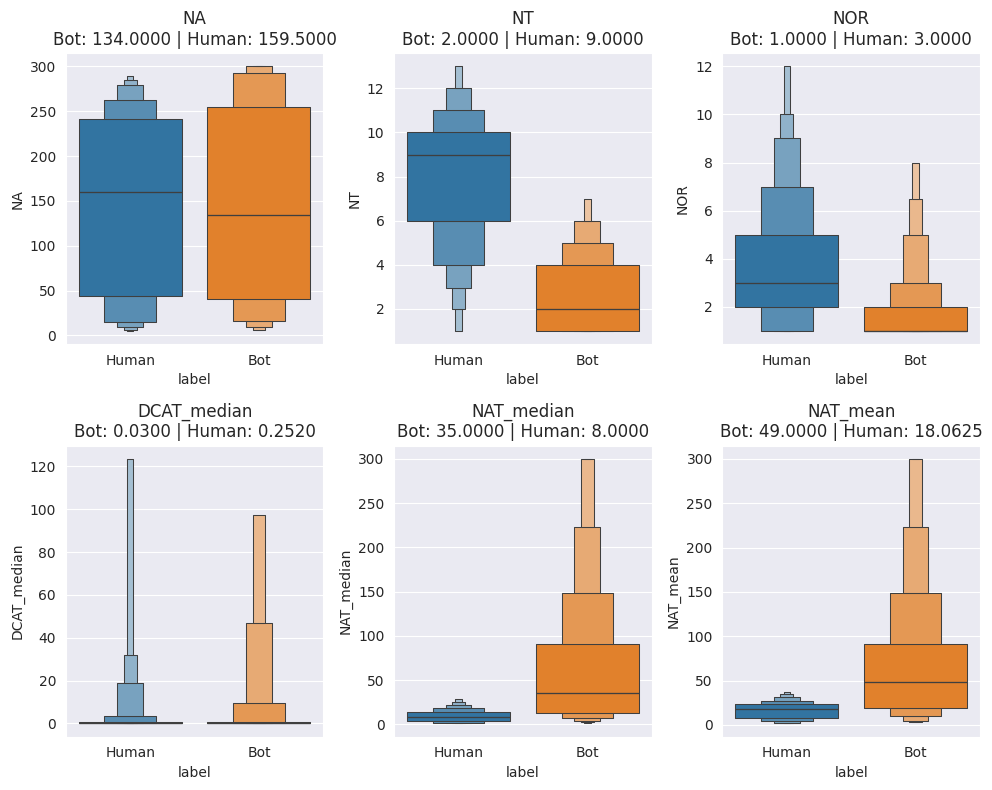

In [18]:
fig, axes = plt.subplots(2, 3, figsize=(10, 8))
for i, col in enumerate(important_features):
    ax = axes[i//3, i%3]
    sns.boxenplot(x='label', y=col, data=glmap_features, ax=ax, showfliers=False, hue='label')

    # Compute medians
    medians = glmap_features.groupby('label')[col].median()
    median_text = ' | '.join([f'{label}: {median:.4f}' for label, median in medians.items()])

    # Set title with median values
    ax.set_title(f'{col}\n{median_text}')

plt.tight_layout()
plt.show()


## 2.2 - Statistical test and effect size analysis (on important features)
> Goal: Analyse if the statistical difference is still present on important features of GitLab dataset

The Mann-Whitney U rejected the null hypothesis of all important features with a significance level of $\alpha = 0.001$.

Moreover, the effect size, Cliff's $\delta$, reveals a *large* difference between bots and human for all these features except for dcat_median which has a *medium* effect size.

In [6]:
# Inspired from https://github.com/natarajan-chidambaram/BIMBAS_RABBIT_replication_package/blob/main/notebooks/BIMBAS_evaluation.ipynb
def test(df, feature, alpha=0.001/38):
    bot = df[df['label'] == 'Bot'][feature].dropna()
    human = df[df['label'] == 'Human'][feature].dropna()
    _, p = stats.mannwhitneyu(bot, human)

    d, size = cliffs_delta(bot, human)

    if p < alpha:
        rejected = True
    else:
        rejected = False
    bot_median = bot.median()
    human_median = human.median()
    return p, rejected, d, size, bot_median, human_median

In [7]:
p_values = []

for feature in important_features:
    if feature == 'NA': continue
    p_value, is_rejected, delta, size, bot_median, human_median = test(glmap_features, feature)
    p_values.append(p_value)

    print(f"================ {feature} ===============")
    print(f"p_value = {p_value} and is_rejected = {is_rejected}")
    print(f"delta = {round(delta,4)}, size = {size}")
    print(f"bot_median = {bot_median}")
    print(f"human_median = {human_median}")

================ NT ===============
p_value = 2.0716269109638424e-68 and is_rejected = True
delta = -0.8276, size = large
bot_median = 2.0
human_median = 9.0
================ NOR ===============
p_value = 5.322056553497107e-37 and is_rejected = True
delta = -0.5745, size = large
bot_median = 1.0
human_median = 3.0
================ DCAT_median ===============
p_value = 8.751483932316852e-12 and is_rejected = True
delta = -0.362, size = medium
bot_median = 0.03
human_median = 0.252
================ NAT_median ===============
p_value = 1.8681936943089866e-42 and is_rejected = True
delta = 0.6499, size = large
bot_median = 35.0
human_median = 8.0
================ NAT_mean ===============
p_value = 5.343341865509863e-35 and is_rejected = True
delta = 0.5876, size = large
bot_median = 49.0
human_median = 18.0625


In [67]:
# family-wise error rate. (Bonferroni-Holm)
from statsmodels.stats.multitest import multipletests

rejected, pvals_corrected, _, _ = multipletests(p_values, alpha=0.001, method='holm')

for feature, p_val, p_val_corr, is_rejected in zip(important_features, p_values, pvals_corrected, rejected):
    print(f"Feature: {feature}")
    print(f"  Original p_value: {p_val:.4g}")
    print(f"  Correct p_value (Holm): {p_val_corr:.4g}")
    print(f"  Rejected with alpha=0.001: {'Yes' if is_rejected else 'No'}")


Feature: NA
  Original p_value: 2.072e-68
  Correct p_value (Holm): 1.036e-67
  Rejected with alpha=0.001: Yes
Feature: NT
  Original p_value: 5.322e-37
  Correct p_value (Holm): 1.597e-36
  Rejected with alpha=0.001: Yes
Feature: NOR
  Original p_value: 8.751e-12
  Correct p_value (Holm): 8.751e-12
  Rejected with alpha=0.001: Yes
Feature: DCAT_median
  Original p_value: 1.868e-42
  Correct p_value (Holm): 7.473e-42
  Rejected with alpha=0.001: Yes
Feature: NAT_median
  Original p_value: 5.343e-35
  Correct p_value (Holm): 1.069e-34
  Rejected with alpha=0.001: Yes


## 2.3 - All plots

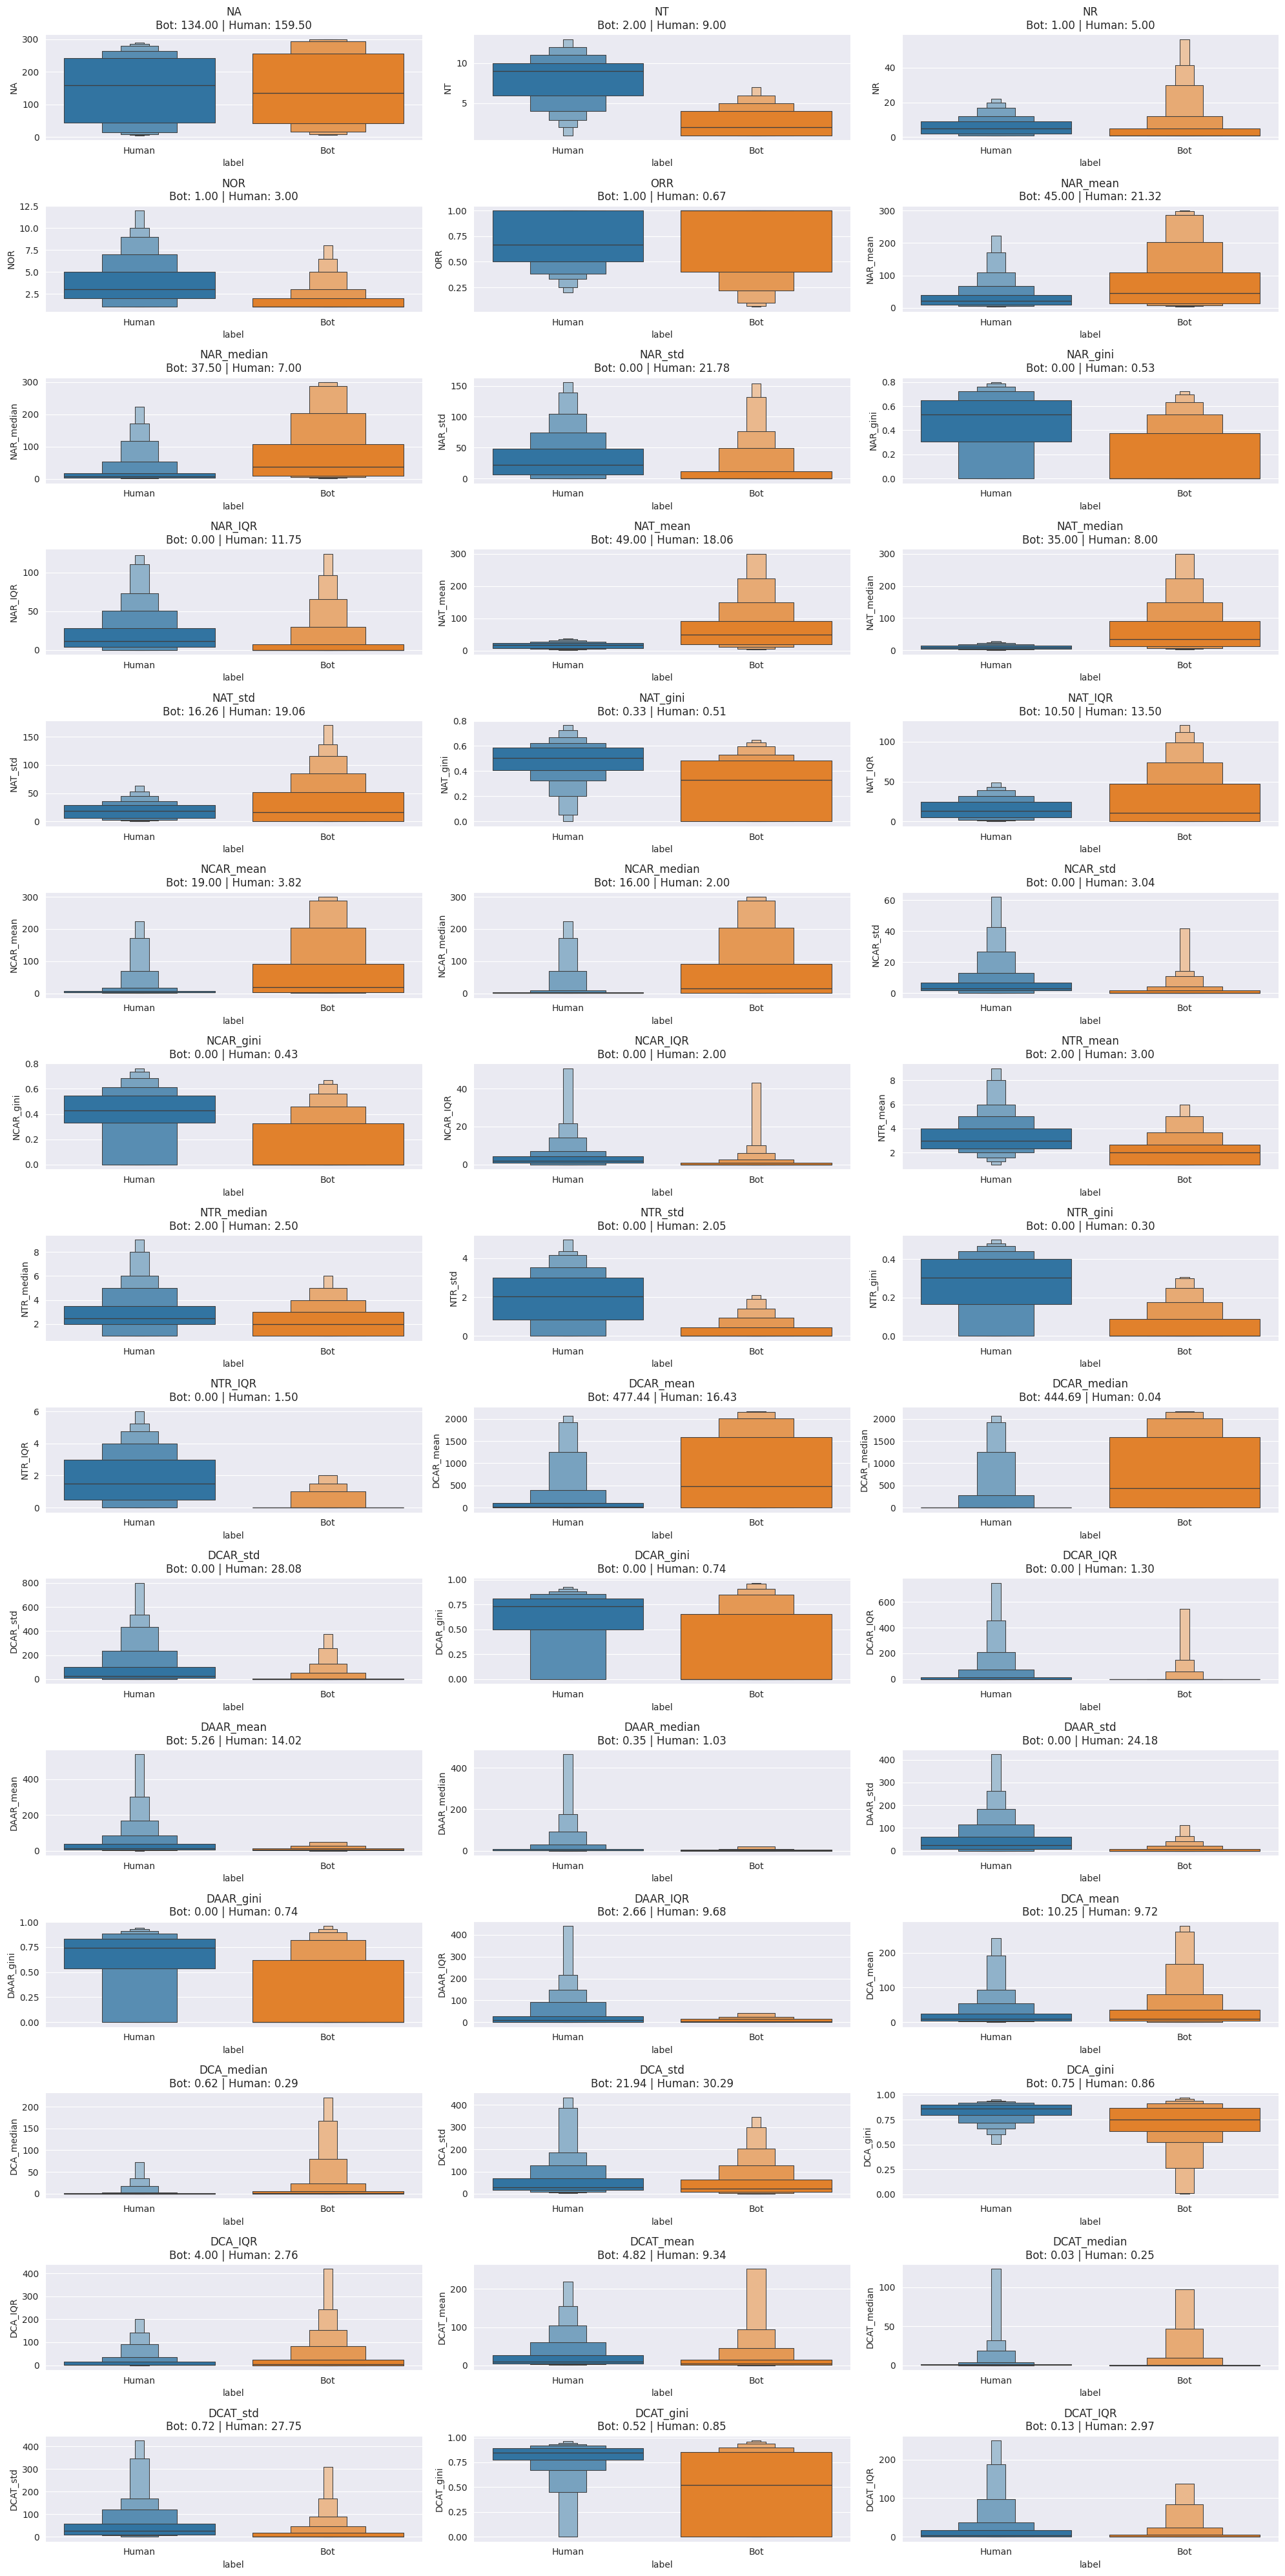

In [21]:
fig, axes = plt.subplots(15, 3, figsize=(20, 40))
for i, col in enumerate(glmap_features.columns[3:-1]):
    ax = axes[i//3, i%3]
    sns.boxenplot(x='label', y=col, data=glmap_features, ax=ax, showfliers=False, hue='label')

    # Compute medians
    medians = glmap_features.groupby('label')[col].median()
    median_text = ' | '.join([f'{label}: {median:.2f}' for label, median in medians.items()])

    # Set title with median values
    ax.set_title(f'{col}\n{median_text}')

plt.tight_layout()
plt.show()


# 3. Feature comparison between GitLab and GitHub
In this section, we will compare the features between GitLab and GitHub (ghmap).
The goal is to see if there are significant differences between the two datasets.

The number of repositories of GitLab contributors seems lower than GitHub contributors. For example, the feature `NR` has a median of 5 for the bots on GitHub but has only a median of 1 in GitLab.

This high number of bots contributing in only one repository leads to many null values for the features analyse the switch between repositories (such as `DAAR`)

In [9]:
rbmap_features = pd.read_csv(f"{RESOURCE_FOLDER}/data/github/new-rbmap_features.csv")
ghmap_features = pd.read_csv(f"{RESOURCE_FOLDER}/data/github/new-ghmap_features.csv")
print(f"Number of contributors in GitHub = {ghmap_features.shape[0]}")
print(f"Number of humans in GitHub = {ghmap_features[ghmap_features['label'] == 'Human'].shape[0]}")
print(f"Number of bots in GitHub = {ghmap_features[ghmap_features['label'] == 'Bot'].shape[0]}")

rbmap_features['dataset'] = 'rbmap'
ghmap_features['dataset'] = 'ghmap'
glmap_features['dataset'] = 'glmap'

Number of contributors in GitHub = 1872
Number of humans in GitHub = 955
Number of bots in GitHub = 917


## 3.1 - Plots of the main features

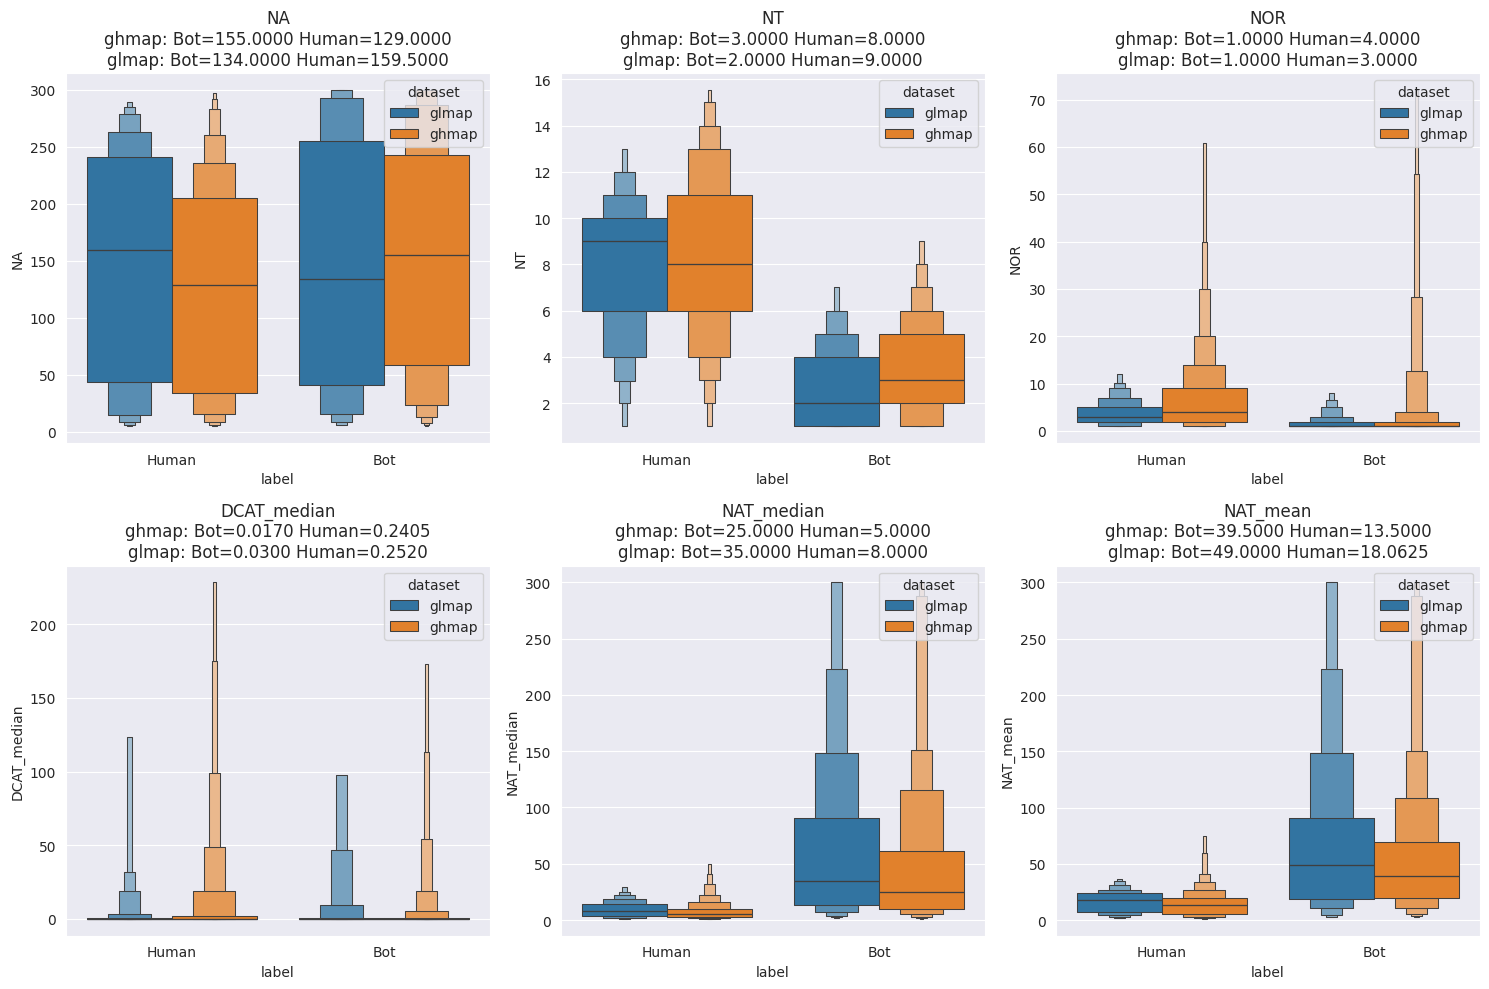

In [13]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

combined_data = pd.concat([glmap_features, ghmap_features], ignore_index=True)

for i, col in enumerate(important_features):
    ax = axes[i//3, i%3]
    sns.boxenplot(x='label', y=col, hue='dataset', data=combined_data, ax=ax, showfliers=False)

    # Add medians on the title of the plot
    medians = combined_data.groupby(['dataset', 'label'])[col].median()
    datasets = medians.index.get_level_values(0).unique()
    title_lines = [col]
    for dataset in datasets:
        line = f'{dataset}:'
        for label in medians.loc[dataset].index:
            median_value = medians.loc[dataset, label]
            line += f' {label}={median_value:.4f}'
        title_lines.append(line)

    ax.set_title('\n'.join(title_lines))


plt.tight_layout()
plt.show()

## 3.2 - Plots of all the features

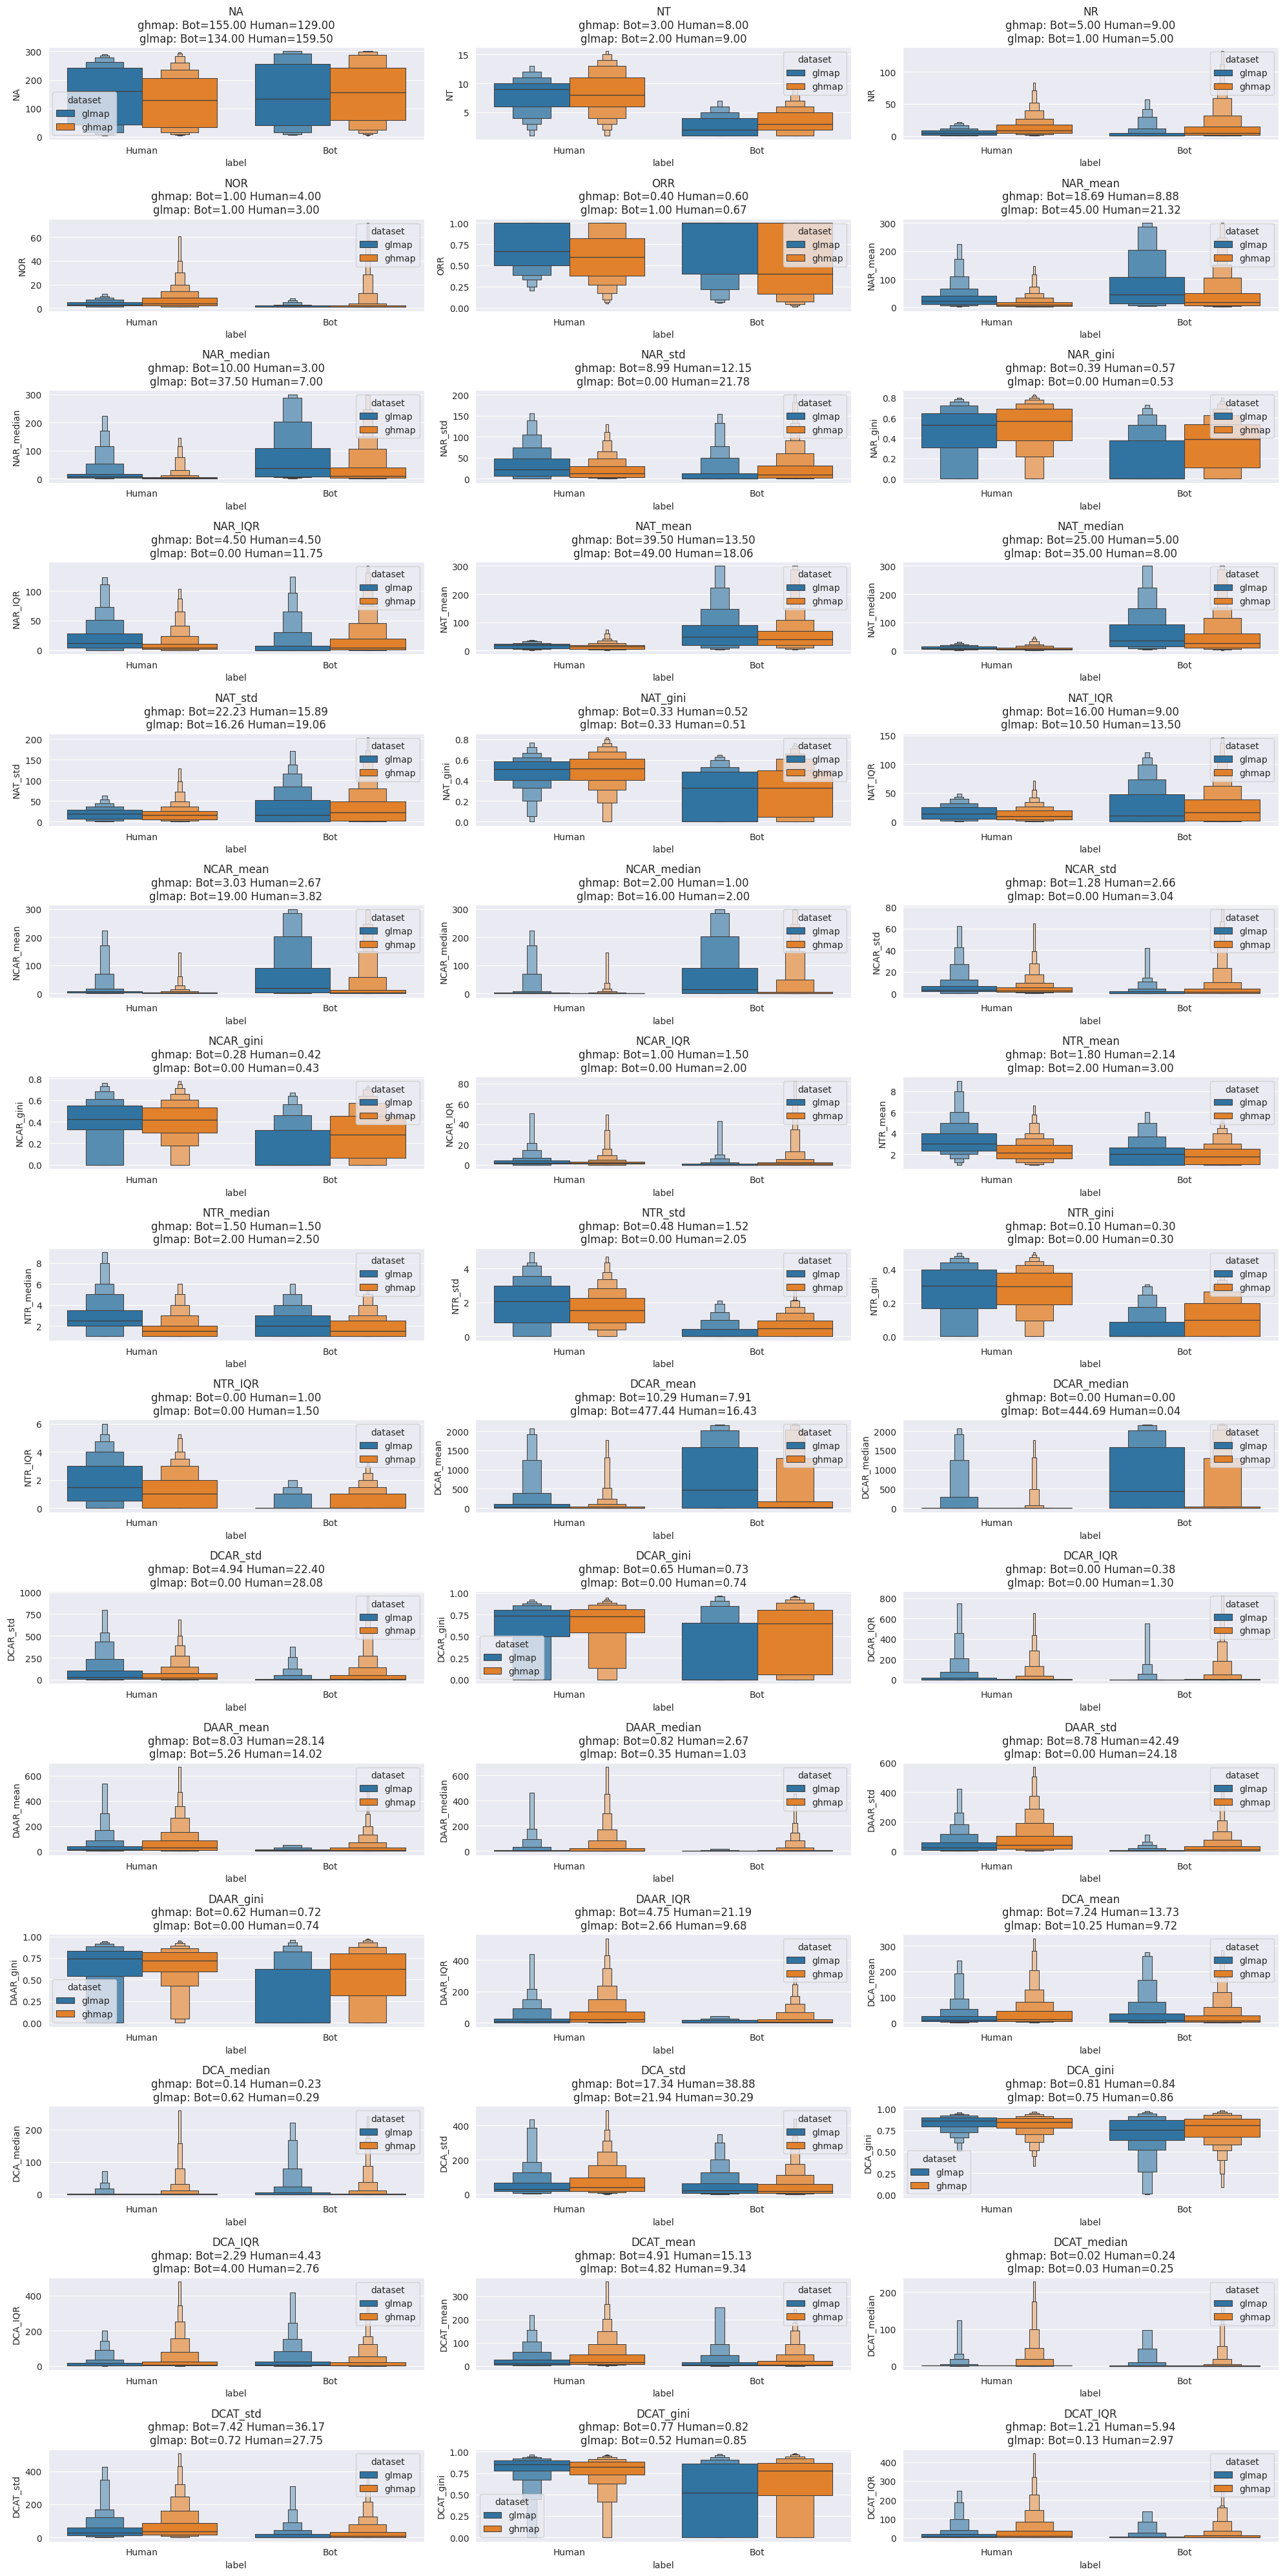

In [69]:
# Combine the datasets
fig, axes = plt.subplots(15, 3, figsize=(20, 40))

for i, col in enumerate(glmap_features.columns[3:-1]):
    ax = axes[i//3, i%3]
    sns.boxenplot(x='label', y=col, hue='dataset', data=combined_data, ax=ax, showfliers=False)

    # Add medians on the title of the plot
    medians = combined_data.groupby(['dataset', 'label'])[col].median()
    datasets = medians.index.get_level_values(0).unique()
    title_lines = [col]
    for dataset in datasets:
        line = f'{dataset}:'
        for label in medians.loc[dataset].index:
            median_value = medians.loc[dataset, label]
            line += f' {label}={median_value:.2f}'
        title_lines.append(line)

    ax.set_title('\n'.join(title_lines))


plt.tight_layout()
plt.show()